# Lesson 05 Assignment - Hypothesis Simulation  

## Author - AlexSkrn



## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods
3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
            Classical tests
            Tukey’s Honest Significant Differences (HSD)
            Bootstrap methods
            Bayesian model


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [2]:
# Load necessary libraries
import itertools
import pandas as pd
import numpy as np
import scipy
import scipy.stats
import numpy.random as nr
from sklearn.preprocessing import scale
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as pyplot
import seaborn as sns
%matplotlib inline

In [3]:
# Load the auto-prices dataset
def read_auto_data(fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"):
    'Function to load the auto price data set from a .csv file' 
    import pandas as pd
    import numpy as np

    ## Read the .csv file with the pandas read_csv method
    auto_price = pd.read_csv(fileName)
    
    ## Remove rows with missing values, accounting for missing values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm', 'normalized-losses']
    for column in cols:
        auto_price.loc[auto_price[column] == '?', column] = np.nan
    auto_price.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_price[column] = pd.to_numeric(auto_price[column])
        
    return auto_price

auto_price = read_auto_data(fileName)

In [4]:
# Define a function to get log prices from the auto_price dataframe, by variable 
# and a category within such variable
def get_log_prices(df, variable, category):
    """Return an array of prices for the variable and category."""
    return df.loc[df[variable] == category].loc[:, 'log_price']

In [5]:
# Add a column with the logs of prices 
auto_price['log_price'] = auto_price['price'].apply(np.log)

## 1. Identify a likely distribution for price and several other features.

### Distribution of log price

In [6]:
# Pick the logs of prices
logdata = auto_price.loc[:, 'log_price']
# Normalize log prices
norm2 = scale(logdata.tolist())
# K-S test to test the distribution for normality
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
ks_test(norm2)    

KS-statistic = 0.12190811341151653
P-value = 0.015712065178210333


Because the p-value is less than the level of significance, alpha = 0.05, I **must reject Ho that the log-transformed price data distribution is normal**. **However**, although the log-transformed prices are not exactly normal, I will rely on the hint in the begining of Lesson 4 assignment that these relationships are approximate, and I'll **consider that the prices are from a log-normal population**.

### Distribution of Losses

(array([ 50.,  75., 100., 125., 150., 175., 200., 225., 250., 275.]),
 <a list of 10 Text xticklabel objects>)

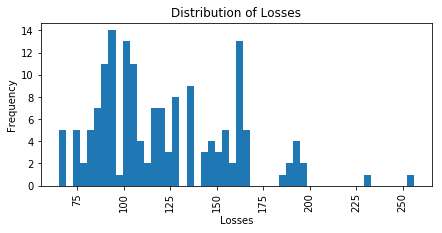

In [7]:
pyplot.figure(figsize=(7,3))
auto_price.loc[:, 'normalized-losses'].astype('float').plot.hist(bins=50)
pyplot.xlabel('Losses')
pyplot.title('Distribution of Losses')
pyplot.xticks(rotation = 'vertical')

In [8]:
losses = scale(auto_price.loc[:, 'normalized-losses'].astype('float').tolist())

In [9]:
# Kolmogorov-Smirnov Test
ks_test(losses)

KS-statistic = 0.12305049455837802
P-value = 0.014348302890591746


Because the p-value is less than the level of significance, alpha = 0.05, I must **reject Ho** that the losses distribution is normal. 

## 2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods

#### Mean and standard deviation by the classical method -- log prices

In [10]:
print('Mean = {:.3f}'.format(auto_price.loc[:, 'log_price'].mean()))

Mean = 9.238


In [11]:
print('Standard deviation = {:.3f}'.format(auto_price.loc[:, 'log_price'].std()))

Standard deviation = 0.441


#### Mean and standard deviation by Bootstrap -- log prices

In [12]:
# Number of trials
n_replicas = 1000
# frac = 1 to take 100% of the data as a sample
price_bootstrap_means = pd.Series([
    auto_price.sample(frac=1, replace=True).log_price.mean()
    for i in range(n_replicas)])

print('Mean = {:.3f}'.format(price_bootstrap_means.mean()))

Mean = 9.238


In [13]:
price_bootstrap_stds = pd.Series([
    auto_price.sample(frac = 1, replace = True).log_price.std()
    for i in range(n_replicas)])

print('Standard deviation = {:.3f}'.format(price_bootstrap_stds.mean()))

Standard deviation = 0.440


#### Mean and standard deviation by the Bayesian method -- log prices

The code below is an adaptation of code from L05-3-IntroductionToBayes

In [14]:
# Number of samples is equal to the # of cases in the auto dataset
num_samples = len(auto_price.loc[:, 'log_price'])
# Sample of cases from the dataset
price = auto_price.sample(n = num_samples)
# Horizontal axis
p = np.linspace(0, 15, num = 1000)
# Prior normal probability distribution
pp = scipy.stats.norm.pdf(p, loc = price.log_price.mean(), scale = 5)
pp = pp / pp.sum() # normalize

def posterior(prior, like):
    """Return an array of estimated posterior distribution.
    
       prior: an array of prior probability distribution
       like: an array of estimated likelihood distribution
    """
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

def comp_like(p, x):
    """Return an array of estimated normal likelihood distribution.
    
       p: horizontal axis: np.linspace()
       x: a data series
    """
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

like_price = comp_like(p, price.log_price)
post_price = posterior(pp, like_price)

Mean = 9.238, Standard deviation = 0.440


## 3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods

#### Classical Confidence Interval - for the mean

What is the proper way to compute C.I. for the mean by the **classical** method? 

#### Approach 1 - from lesson 5

In [15]:
# Approach from notebook L05-CentralLimitTheorem
pop_mean = auto_price.loc[:, 'log_price'].mean()
pop_std = auto_price.sample(frac = 1, replace = True).log_price.std()
alpha = 0.95
half_width = scipy.stats.norm.ppf((1 + alpha) / 2, loc = pop_mean, scale = pop_std) - pop_mean
print('The half width is %.2f' % half_width)

ci_low = pop_mean - half_width
ci_high = pop_mean + half_width

print('The %.2f level CI is (%.2f , %.2f)' % (alpha, ci_low, ci_high))

The half width is 0.88
The 0.95 level CI is (8.36 , 10.12)


#### Approach 2 - from the Internet - same result

In [16]:
# Using scipy.stats.t.interval() produces the same result as the approach in this Lesson 05
mu = auto_price.log_price.mean()
sd = auto_price.log_price.std()
conf_int_t = scipy.stats.t.interval(alpha = 0.95,           # Confidence level
                              df = len(auto_price.log_price) - 1,      # Degrees of freedom
                              loc = mu,               # Sample mean
                              scale = sd)             # Sample standard deviation
print('({:.3}, {:.3})'.format(conf_int_t[0], conf_int_t[1]))

(8.37, 10.1)


#### Approach 3 - from the Internet - different result but coincides with the C.I. by Bootstrap

In [17]:
# Approach from https://kite.com/python/examples/702/scipy-compute-a-confidence-interval-from-a-dataset
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95
data = auto_price.loc[:, 'log_price']

n = len(data)
m = mean(data)
std_err = sem(data)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print('({:.3f}, {:.3f})'.format(start, end))

(9.169, 9.307)


It is interesting that the last result coincides with the Bootstrap C.I. below.

#### Bootstap Confidence Interval - for the mean of log prices

In [18]:
# Using price_bootstrap_means calculated above in Section 2 (Mean and std by Bootstrap)
p = 5  # 95% confidence level
lo = np.percentile(price_bootstrap_means, p/2.)
hi = np.percentile(price_bootstrap_means, 100-p/2.)
print('({:.3}, {:.3})'.format(lo, hi))

(9.17, 9.31)


#### Credible Interval by the Bayesian method - for the mean of log prices

Mean = 9.238, Standard deviation = 0.440
The 0.950 credible interval is 9.169 to 9.305


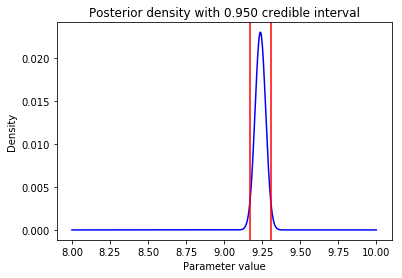

In [19]:
# Adaptation of code from L05-3-IntroductionToBayes
def plot_ci(p, post, num_samples, lower_q, upper_q):
    """This function computes a credible interval.
    
    Uses an assumption of symmetry in the bulk of the distribution 
    to keep the calculation simple."""
    
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    pyplot.title('Posterior density with %.3f credible interval' % interval)
    pyplot.plot(p, post, color='blue')
    pyplot.xlabel('Parameter value')
    pyplot.ylabel('Density')
    pyplot.axvline(x=ci[0], color='red')
    pyplot.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, ci[0], ci[1]))

num_samples = 100000
lower_q, upper_q = [.025, .975]
p = np.linspace(8, 10, num = 1000)

# Prior normal probability distribution
pp = scipy.stats.norm.pdf(p, loc = auto_price.log_price.mean(), scale = 5)
pp = pp / pp.sum() # normalize

L = comp_like(p, auto_price.log_price)
post = posterior(pp, L)
plot_ci(p, post, num_samples, lower_q, upper_q)

## 4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
     Classical tests
     Tukey’s Honest Significant Differences (HSD)
     Bootstrap methods
     Bayesian model

### Classical tests

##### T-test for the difference between the means - car prices by number of doors (four vs two)

In [20]:
def t_test(a, b, alpha, alternative='two-sided'):
    """Return results of Welche's test for paired data."""
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   


In [21]:
two_door = get_log_prices(auto_price, 'num-of-doors', 'two')
four_door = get_log_prices(auto_price, 'num-of-doors', 'four')
test = t_test(two_door, four_door, 0.05)
test

DegFreedom    128.285485
Difference     -0.193799
Statistic      -2.765439
PValue          0.006366
Low95CI        -0.334524
High95CI       -0.053075
dtype: float64

Because the p-value is below a = 0.05, I must **reject Ho** that there is no difference in the means. So the **difference** between the mean log prices of four-door cars and two-door cars is **significant**.

#### Anova analysis of the differences of the means in log prices by 4 vs 2-door cars

In [22]:
# What door number types are there?
unique_door_nums = auto_price.loc[:, 'num-of-doors'].unique()
unique_door_nums


array(['four', 'two', '?'], dtype=object)

In [23]:
# Get a list of fuel system type names and prices if the # of cases in each group excceds 5
all_door_nums = []
num_door_names = []
for cat in ['four', 'two']:
    price = get_log_prices(auto_price, 'num-of-doors', cat)
    if len(price) > 5:
        num_door_names.append(cat)
        all_door_nums.append(price)

In [24]:
print('# of cases in each category')
door_nums = [len(i) for i in all_door_nums]
door_nums

# of cases in each category


[95, 64]

In [25]:
# Anova analysis
f_statistic, p_value = scipy.stats.f_oneway(*all_door_nums)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 7.647654877199709
P-value = 0.0063663162386156285


Because the p-value is very small, I must **reject Ho** that there is no difference among the mean prices by number-of-door type.

### Tukey’s Honest Significant Differences (HSD)

In [26]:
# The variables used here are defined in the previous section on Anova
df = pd.DataFrame({'vals': list(itertools.chain.from_iterable(all_door_nums)),
                   'group_num': [num_door_names[0]] * door_nums[0] 
                              + [num_door_names[1]] * door_nums[1] 
                  })
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 four   two   -0.1938  -0.3322 -0.0554  True 
---------------------------------------------


The above table shows that the only two groups I am comparing have significantly different means, with a recommendation to **reject Ho** and infere that the **difference is significant**.

### Bootstrap method

##### Difference in means between two categories

First I define a couple of helper functions: one to get the differences in means between two categories of the chosen variable by Bootstrap method; and another to plot histograms of the difference in means, with the Confidence Interval shown.

In [27]:
def bootstrap_mean_diff_prices(df, variable, categories, n_replicas, fraction):
    """Return a pandas.series of differences in means for log prices."""
    mean_diff = []
    for i in range(n_replicas):
        sample = df.sample(frac = fraction, replace = True)
        categ_one_mean = get_log_prices(sample, variable, categories[0]).mean()
        categ_two_mean = get_log_prices(sample, variable, categories[1]).mean()
        mean_diff.append(categ_two_mean - categ_one_mean)
    return pd.Series(mean_diff)

In [28]:
def plot_hist(x, p=5):
    """Plot the distribution and mark the mean."""
    pyplot.hist(x, alpha=.5)
    pyplot.axvline(x.mean())
    # 95% confidence interval    
    pyplot.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    pyplot.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)

#### Bootstrap difference in means of log prices by the number of car doors 4 vs 2-door cars

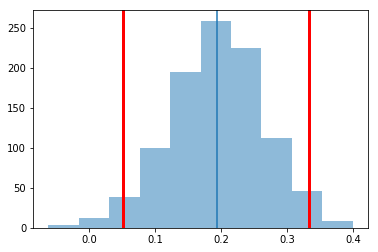

In [29]:
diff_prices_fuel = bootstrap_mean_diff_prices(auto_price,       ## dataframe
                                              'num-of-doors',   ## variable
                                              ['two', 'four'],  ## categories
                                              n_replicas,       ## number of trials
                                              1                 ## sample size, 1 = 100%
                                             )

plot_hist(diff_prices_fuel)

**Reject Ho**: For the difference of means of log-prices by the number of doors, the C.I. of the **difference of means does not include zero**. I infer that the means of the two populations are **significantly different**.

### Bayesian model

   ##### Difference in log prices by number of doors (two vs four)

Calculate the Credible Interval for the mean price estimate for four-door cars.

Mean = 9.318, Standard deviation = 0.418
The 0.950 credible interval is 9.233 to 9.401


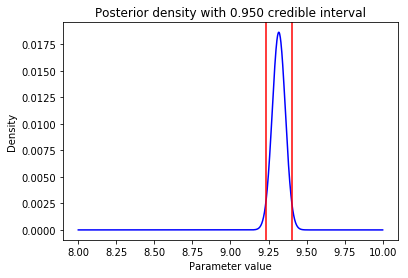

In [30]:
num_samples = 100000
lower_q, upper_q = [.025, .975]
# Horizontal axis
p = np.linspace(8, 10, num = 1000)

# Prior normal probability distribution
pp = scipy.stats.norm.pdf(p, loc = auto_price.log_price.mean(), scale = 5)
pp = pp / pp.sum() # normalize

L = comp_like(p, get_log_prices(auto_price, 'num-of-doors', 'four'))
post = posterior(pp, L)
plot_ci(p, post, num_samples, lower_q, upper_q)

Now, calculate the Credible Interval for the mean price estimate for cars for two-door cars.

Mean = 9.124, Standard deviation = 0.449
The 0.950 credible interval is 9.015 to 9.233


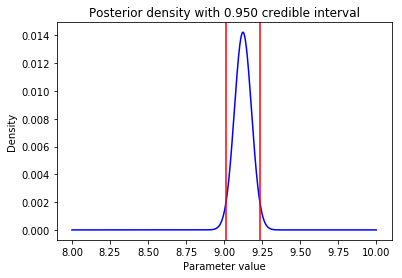

In [31]:
L = comp_like(p, get_log_prices(auto_price, 'num-of-doors', 'two'))
post = posterior(pp, L)
plot_ci(p, post, num_samples, lower_q, upper_q)

Because the credible intervals **overlap only slightly if at all**, I think I should **reject Ho** that there is no difference in the mean prices for four vs two-door cars. So this is more likely than not that the **difference is significant**.